# Multiclass Classification

## One vs All

#### Import Data

In [1]:
%matplotlib inline
import numpy as np
import scipy.io # used for opening .mat files
import matplotlib.pyplot as plt
import scipy.misc # converts matrix to image
import matplotlib.cm as cm # used for grayscale colormap
from scipy import optimize
from math import ceil

In [2]:
filename = 'ex3data1.mat'
data = scipy.io.loadmat(filename)
data #stored as a dictionary

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X_raw = data['X']
y_raw = data['y']
print('X_raw shape:',X_raw.shape, '|' ,'y_raw shape:',y_raw.shape)

X_raw shape: (5000, 400) | y_raw shape: (5000, 1)


#### Data Visualization
Currently, 5000 20x20 pixel images are stored in the X_raw matrix. These images can be visualized by plotting pixels as they correspond to grayscale intensities.

In [4]:
def formImage(row, width=20, height=20):
    """row: numpy row of values
       returns values in row in an array with dimensions width and height. 
       Length of row should equal width * height"""
    image = row.reshape((width,height)) #haven't inserted ones before X yet
    return image.T

In [5]:
def plotImage(X, specific_row=[]):
    """X: numpy array with entries in rows, pixels in columns
       width, height: width, height of one sub-image
       specific_row: numpy array of indices of a specific row in X you want to plot"""
    #logic to control if it's one image or a bunch of images
    width,height = 20,20
    if np.array([specific_row]).size != 0:
        X = X[specific_row,:].reshape((np.array([specific_row]).T.shape[0],X.shape[1])) #sets plotted data to the one item
        plotcols, plotrows = 10, 10 #ceil(np.array([specific_row]).shape[1] / 10)
    else:
        X = X[np.random.randint(X.shape[0],size=100),:]
        plotcols, plotrows = 10, 10
        
    #makes bigpicture matrix
    bigpic = np.zeros((plotrows*height, plotcols*width))
    
    index = 0
    for i in range(0,plotrows):
        for j in range(0,plotcols):
            bigpic[i*height:(i+1)*height,j*width:(j+1)*width] = formImage(X[index,:], width, height)
            if np.array([specific_row]).size != 0 and index == np.array([specific_row]).shape[1] - 1:
                break
            index += 1
        if np.array([specific_row]).size != 0 and index == np.array([specific_row]).shape[1] - 1:
            break
    #there is definitely a more elegant way to make the bigpic display if you don't have 100 indices in specific_row
    
    #plots picture
    fig = plt.figure(figsize=(6,6))
    pic = scipy.misc.toimage(bigpic)
    plt.imshow(pic,cmap = cm.Greys_r)
    # future: have it show if there are less than 100 specific rows

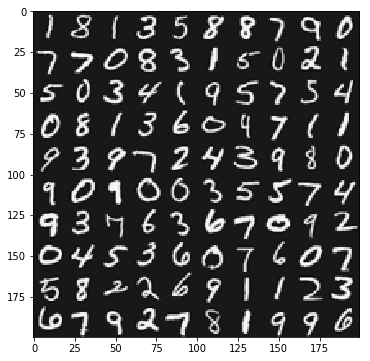

In [6]:
plotImage(X_raw)

#### Logisitic Functions

In [7]:
def sigmoid(X):
    """X: int, np array
       returns sigmoid of x"""
    return 1 / (1 + np.exp(-X))

In [8]:
def h(X,theta):
    """Hypothesis function with signoid and dot product of X and theta"""
    return sigmoid(np.dot(X,theta))

In [9]:
def cost(theta, X, y, lamda=0):
    """Returns the cost of the function evaluated at X, y, theta, and lambda. For no regularization, lambda stays zero.
        X: np array of testing examples
        y: np array of testing results
        theta: np array of theta values
        lamda: int, lambda, the regularization hyperparameter"""
    #print('cost1',theta.shape)
    #print(theta)
    #theta = theta.reshape((theta.shape[0],1))
    theta = theta.reshape((np.max(theta.shape),1))
    #print('cost2',theta.shape)
    #print(theta)
    m = X.shape[0]
    J = 1 / m * (np.dot(-y.T, np.log(h(X,theta))) - np.dot((1 - y).T, np.log(1 - h(X,theta)))) + lamda * np.dot(theta[1:,:].T, theta[1:,:]) / (2*m)
    
    return J

In [10]:
def grad(theta, X, y, lamda=0):
    """Returns the gradient of the cost function evaluated at theta.
        X: np array of testing examples
        y: np array of testing results
        theta: np array of theta values
        lamda: int, lambda, the regularization hyperparameter"""
    
    theta = theta.reshape((np.max(theta.shape),1))
    #print('grad', theta.shape)
    m = X.shape[0]
    gradient = np.zeros(theta.shape)
    gradient[0,:] = 1 / m * np.dot(X[:,0].T, h(X,theta)-y)
    gradient[1:,:] = (1 / m * np.dot(X[:,1:].T, h(X,theta)-y) + lamda * theta[1:,0:] / m)
    #print('gradient', gradient.shape)
    return gradient.flatten()

In [11]:
def oneVsAll(X, y, num_labels, lamda=0):
    """Performs oneVsAll classification to classify values in X
        X: np array of testing examples, with examples in rows, and features in columns
        y: np array with the correct classification for each row of X
        lamda: int, lambda, the regularization hyperparameter
        num_labels: number of different categories to classify into"""
    
    X = np.insert(X, 0, 1, axis=1)
    
    all_theta = np.zeros((num_labels,X.shape[1]))
        
    for i in range(num_labels):
        print('Training for group',i)
        thetas = all_theta[i,:].reshape((1,all_theta.shape[1])).T
        classnumber = i if i else 10 # sets the written character number as the class to train for
        y_group = np.array(y==classnumber).astype(int) # sets y to be 1 if it is in training class, else 0

        #results = optimize.fmin(cost, x0=thetas, args=(X, y_group, lamda), maxiter=500, full_output=True)
        #results = optimize.fmin_cg(cost, fprime=grad, x0=thetas.flatten(), args=(X, y_group, lamda), maxiter=100, full_output=True)
        results = optimize.fmin_tnc(cost, fprime=grad, x0=thetas.flatten(), args=(X, y_group, lamda))
        res_theta = results[0]
        all_theta[i,:] = res_theta.T
    
    return all_theta #returns 10x401 matrix #fmin_cg maxiter =100

In [12]:
def predictOVA(ova_theta, X):
    return np.argmax(np.dot(X, ova_theta.T), axis=1).reshape((X.shape[0],1))

#### One Versus All

In [13]:
ova_theta = oneVsAll(X_raw,y_raw,10,0.1)
ova_theta

Training for group 0
Training for group 1
Training for group 2
Training for group 3
Training for group 4
Training for group 5
Training for group 6
Training for group 7
Training for group 8
Training for group 9


array([[ -8.06662700e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -3.54345850e-05,   9.63775047e-07,   0.00000000e+00],
       [ -3.07719891e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.82814191e-03,   3.65551176e-11,   0.00000000e+00],
       [ -3.73153824e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.32999416e-02,  -2.55561829e-03,   0.00000000e+00],
       ..., 
       [ -2.29272021e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -6.64588560e-03,   7.78926948e-04,   0.00000000e+00],
       [ -9.12815892e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -6.15570973e-04,   6.94734530e-05,   0.00000000e+00],
       [ -5.62499072e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.12348127e-02,   8.54115687e-04,   0.00000000e+00]])

In [14]:
a = predictOVA(ova_theta, np.insert(X_raw,0,1,axis=1)) #predicting number classifications

In [15]:
y_raw[y_raw==10] = 0 #setting class ten to written number 0, which is predicted

In [16]:
print('Training Accuracy:',np.mean((a == y_raw).astype(int)) * 100,'%') # Learning accuracy

Training Accuracy: 96.46 %


[ 142  561  675  765 1026 1045 1057 1066 1081 1087 1097 1112 1130 1145 1153
 1213 1231 1311 1362 1393 1399 1408 1410 1413 1423 1440 1484 1488 1524 1527
 1550 1556 1564 1599 1607 1611 1617 1626 1629 1630 1700 1701 1707 1719 1732
 1764 1766 1769 1776 1791 1798 1801 1820 1876 1923 1959 1970 1976 1981 1999
 2087 2093 2112 2118 2166 2171 2187 2195 2238 2277 2384 2498 2506 2516 2520
 2533 2556 2570 2574 2578 2593 2598 2616 2618 2619 2620 2675 2697 2718 2788
 2790 2869 2908 2937 2943 2947 2958 3174 3328 3382 3616 3627 3629 3660 3668
 3722 3725 3732 3795 3823 3830 3838 3895 3909 3972 4030 4032 4057 4069 4076
 4100 4110 4125 4168 4177 4183 4197 4248 4249 4250 4252 4265 4294 4306 4319
 4325 4362 4364 4393 4395 4422 4428 4454 4455 4471 4477 4503 4506 4509 4526
 4531 4568 4576 4582 4590 4593 4619 4636 4639 4703 4752 4769 4781 4783 4793
 4799 4833 4844 4860 4863 4865 4902 4917 4930 4969 4990 4999] 
 [8 5 8 2 7 1 5 8 4 9 8 8 9 4 9 0 8 8 8 8 8 6 8 4 8 1 3 7 5 7 7 5 2 2 5 8 9
 2 2 5 4 7 1 9 8 7 5 5 5 

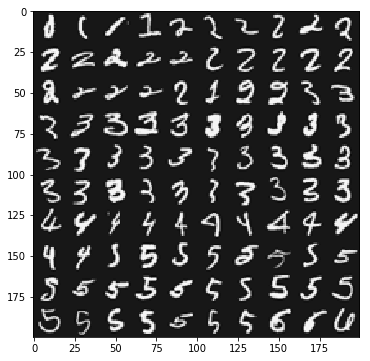

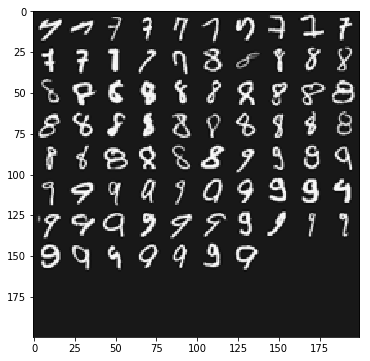

In [17]:
i = np.where(y_raw != a) #finding indices where predictions != real classifications
#X_raw[np.where(i[0]),:] 
#(np.array([i[0]]).shape[1]
print(i[0],'\n',a[i]) #printing incorrect prediction indices and corresponding results
plotImage(X_raw, specific_row=i[0][0:100])
plotImage(X_raw, specific_row=i[0][100:200])

Check to make sure that the errors are relatively evenly distributed and understandable. Currently, they error distribution looks fine.

#### Results
I spent a long time trying different solvers and different settings and tweaking the logistic regression to get a working result. I learned 2 things:
1. The result is dependent on the solver use. As you can see in the code above, I tried 3 different solvers, to different degrees of accuracy. fmin_cg had a lot of difficulty converging when I was training for the written number 8. It would only run a few iterations, and print a precision loss error. In the future, I will try a few different solvers.
2. It is very easy to get sucked into the numpy rabbit hole. At this point, I do not see a use for 1-D arrays that justifies them being the standard in numpy.

## Neural Networks

#### Load data

In [18]:
filename = 'ex3weights.mat'
data = scipy.io.loadmat(filename)
data; #stored as a dictionary

In [19]:
Theta1 = data['Theta1']
Theta2 = data['Theta2']
print('Theta1 shape:',Theta1.shape, '|' ,'Theta2 shape:',Theta2.shape)

Theta1 shape: (25, 401) | Theta2 shape: (10, 26)


#### Neural Network Functions

In [20]:
def predictNN(X, Theta1, Theta2):
    X = np.insert(X, 0, 1, axis=1)
    
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    p = np.argmax(a3, axis=1) + 1
    
    return p.reshape(p.shape[0],1)

#### Testing Pretrained Neural Net

In [21]:
p = predictNN(X_raw,Theta1,Theta2)

In [22]:
y_raw[y_raw==0] = 10
print("Training Accuracy:",np.mean((p == y_raw).astype(int)) * 100,'%')

Training Accuracy: 97.52 %


[ 142  261  265  392  521  531  561  637  675  765  844  908  952 1006 1026
 1057 1087 1153 1213 1363 1399 1406 1408 1413 1423 1440 1484 1494 1524 1550
 1564 1588 1599 1611 1617 1630 1700 1701 1707 1764 1766 1776 1798 1905 1923
 1959 1970 1976 2078 2087 2108 2112 2166 2171 2187 2195 2201 2238 2282 2361
 2384 2393 2467 2498 2506 2556 2570 2593 2601 2606 2693 2908 3043 3078 3081
 3204 3328 3341 3382 3537 3619 3627 3629 3664 3668 3725 3732 3795 3823 3830
 3853 3895 3909 3972 4032 4057 4069 4183 4256 4306 4393 4428 4477 4506 4509
 4519 4531 4568 4582 4593 4627 4636 4639 4708 4790 4833 4844 4860 4863 4865
 4902 4917 4936 4990] 
 [ 8  9  4  6  3  7  8  4  8  2  8  4  9  6  7  5  9  4 10  4  8  6  6  4  8
  1 10 10  5  7  2  6  2  8  9  5  5  7  1  7  5  5  5  5  9  1  7  5  9  6
  2  1  1  9  9  2  9  9  8  6  9  9  6  9  3  2  4  3  6  3  3  6 10  5  1
  1  5  5 10  1  4  4  4  4  9 10  2  2  9  1  9  1  3  9  4  1  2  1  5  1
  4  1  3  5 10  7  7  4  8 10  8  3  3  7  6  3  1  1  7  8  7 

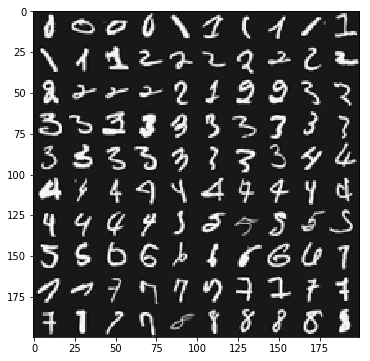

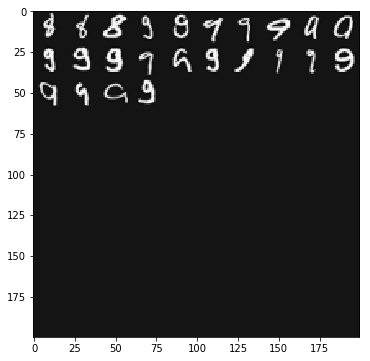

In [23]:
i = np.where(y_raw != p) #finding indices where predictions != real classifications
print(i[0],'\n',p[i])
plotImage(X_raw, specific_row=i[0][0:100])
plotImage(X_raw, specific_row=i[0][100:200])

With a pretrained neural net, we achieve better accuracy than with the one vs all logistic regression.